<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_SE_CPMG_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pypulseq &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

(SE_CPMG_seq)=
# Spin Echo - CPMG

In [2]:
import numpy as np

import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'CPMG'
# %% S1. SETUP sys
# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=50 * 10e-6
)

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


0.00796
Calculating repetition 7 / 7 - done


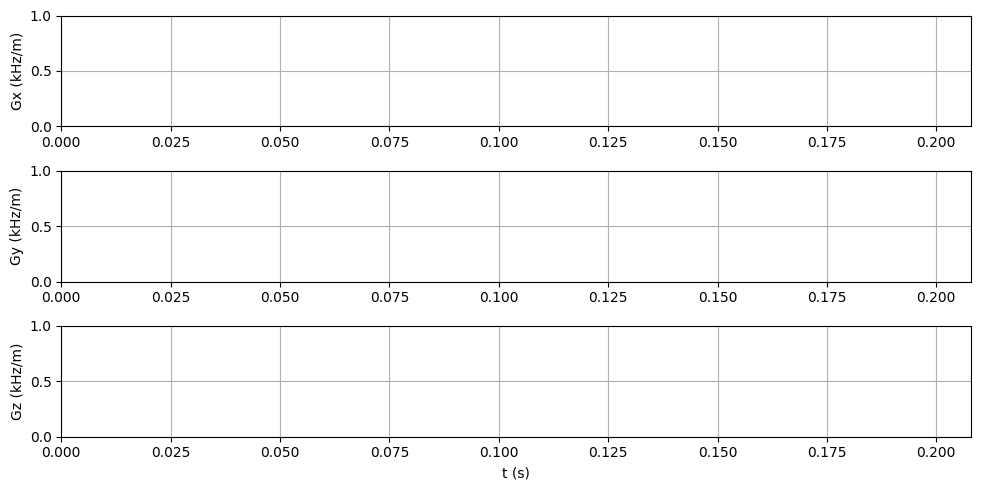

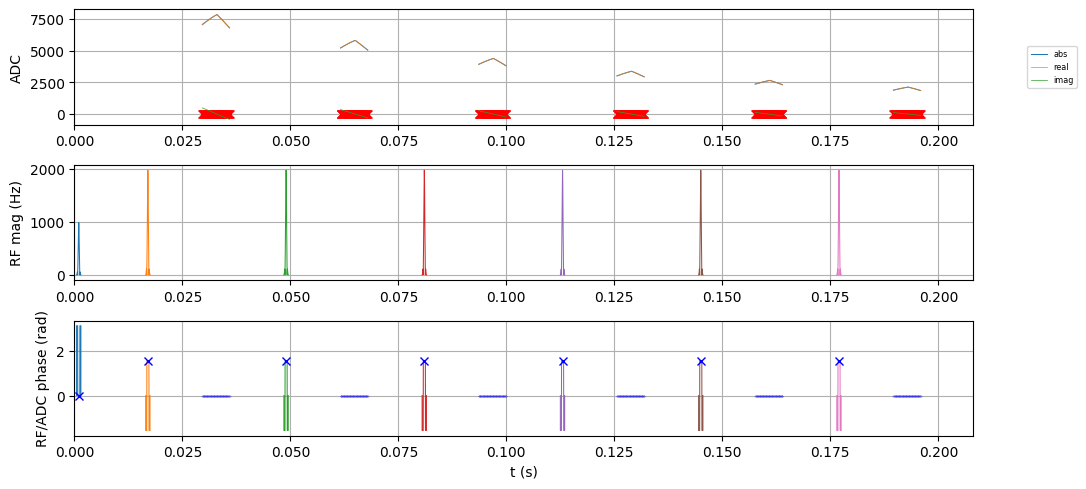

In [34]:
#@title CMPG in a brain phantom - sequence
# %% DEFINE the sequence, FOV and resolution
seq = pp.Sequence()
fov = 200e-3
Nread = 64    #@param {type:"slider", min:0, max:512, step:1}
Nphase = 1
slice_thickness = 8e-3  # slice
refocusing_angle=180 #@param {type:"slider", min:0, max:360, step:1}
# Define rf events
ETL=6 #@param {type:"slider", min:1, max:32, step:1}
TE_ms=32 #@param {type:"slider", min:8, max:32, step:1}
TE_ms*=1e-3

rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    delay=0, system=system, return_gz=True
)
# rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)
rf2, _, _ = pp.make_sinc_pulse(
    flip_angle=refocusing_angle * np.pi / 180, duration=1e-3, phase_offset=90 * np.pi / 180,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
# Define other gradients and ADC events
dwell_time=1e-4
adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell_time, phase_offset=0 * np.pi / 180, system=system)
minTE = pp.calc_duration(adc)+pp.calc_duration(rf1)
print(minTE)
TEdelay=(TE_ms-minTE)/2
if TEdelay<0: TEdelay=0

# ======
# CONSTRUCT SEQUENCE
# ======
seq.add_block(rf1)
seq.add_block(pp.make_delay(TEdelay+minTE/2 - pp.calc_duration(rf1)))
for i in range(0, ETL):
    seq.add_block(rf2)
    seq.add_block(pp.make_delay(TEdelay))
    seq.add_block(adc)
    seq.add_block(pp.make_delay(TEdelay))

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
#quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


In [36]:
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'CPMG')
seq.write(experiment_id + ".seq")

Timing check passed successfully


'a17ea194279287fa97df72ba1be7806b'